In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

#Load Model
model = ResNet9(3, 10)
model = model.to(device)
model.load_state_dict(torch.load("cifar10-resnet9.pth"))
model.eval()

#Load Second Model With last Linear Layer Deleted
model2 = ResNet9(3, 10)
model2 = model2.to(device)
model2.load_state_dict(torch.load("cifar10-resnet9.pth"))
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return F.relu(x)
model2.classifier[3] = Identity()
model2.eval()

#Data Set is stored externally from this folder as to not overencumber GitHub Repository
from torchvision.datasets.utils import download_url
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '../CiFar10-Data Set')
import os, tarfile
try:
    if (len(os.listdir('../CiFar10-Data Set/cifar10')) == 2):
        pass
except:
    with tarfile.open('../CiFar10-Data Set/cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='../CiFar10-Data Set')

Using downloaded and verified file: ../CiFar10-Data Set\cifar10.tgz


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
data_dir = '../CiFar10-Data Set/cifar10'
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
tfms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean, std)]
)
test_data_set = ImageFolder(data_dir+'/test', transform=tfms)
dl = torch.utils.data.DataLoader(test_data_set, batch_size=1, shuffle=False)

In [4]:
def BIM_test(model, device, dl, epsilon, alpha, steps):
    images = []
    adversarial_images = []
    correct = 0
    
    for img, label in dl:
        img, label = img.to(device), label.to(device)

        curr_img = img
        curr_img.requires_grad = True
        output = model(curr_img)

        if output.max(1, keepdim=True)[1] != label:
            continue
        
        images.append((img.cpu(), label.cpu()))
        for i in range(steps):
            loss = F.cross_entropy(output, label)

            model.zero_grad()
            loss.backward()

            data_grad = curr_img.grad.data.sign()

            perturbed_image = img + (alpha*data_grad)

            total_grad = perturbed_image - img

            total_grad = torch.clamp(total_grad, -epsilon, epsilon)

            perturbed_image = img + total_grad

            curr_img = perturbed_image.clone().detach()

            curr_img.requires_grad = True

            output = model(curr_img)

        final_pred = output.max(1, keepdim=True)[1]

        if final_pred == label:
            correct += 1
        else:
            adversarial_images.append((perturbed_image.cpu(), label.cpu()))
        
    return correct/len(dl), adversarial_images, images

In [5]:
epsilon = 1
alpha = .25
num_steps = 10
accuracy, adv_imgs, test_images = BIM_test(model, device, dl, epsilon, alpha, num_steps)

In [6]:
print(accuracy)
print(len(adv_imgs))
print(len(test_images))

0.0756
8470
9226


In [7]:
outputs = np.empty((len(test_images) + len(adv_imgs), 512))
labels = []
x=0
for img, label in test_images:
    img = img.to(device)
    output = model2(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(test_data_set.classes[int(label.item())])
    x += 1

for img, label in adv_imgs:
    img = img.to(device)
    output = model2(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(test_data_set.classes[int(label.item())])
    x += 1

print(outputs.shape)
print(len(labels))
print(x)

(17696, 512)
17696
17696


In [8]:
#Fit with all data
pca1 = PCA(n_components=2)
pca1_data = pca1.fit_transform(outputs)
df1 = pd.DataFrame(data = pca1_data
             , columns = ['principal component 1', 'principal component 2'])

#Fit with real images
pca2 = PCA(n_components=2)
pca2.fit(outputs[:9226])
pca2_data = pca2.transform(outputs)
df2 = pd.DataFrame(data = pca2_data
             , columns = ['principal component 1', 'principal component 2'])

#Fit with adversarial images
pca3 = PCA(n_components=2)
pca3.fit(outputs[9226:])
pca3_data = pca3.transform(outputs)
df3 = pd.DataFrame(data = pca3_data
             , columns = ['principal component 1', 'principal component 2'])

<Figure size 2160x2160 with 0 Axes>

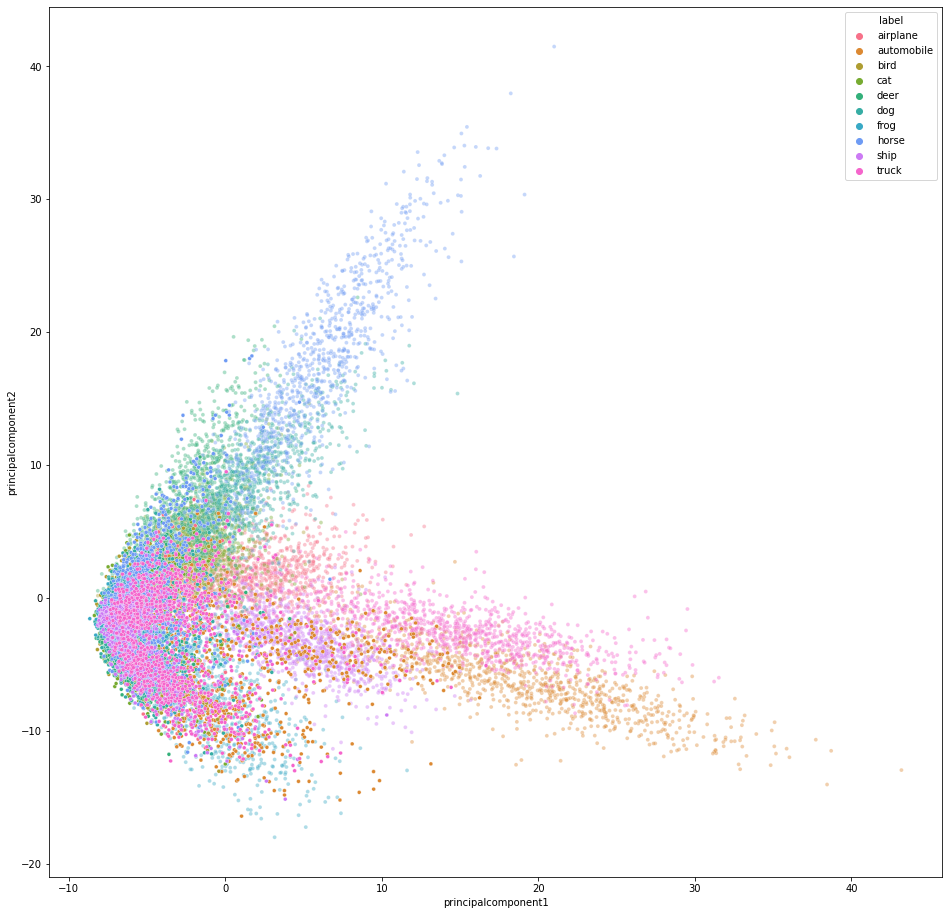

<Figure size 2160x2160 with 0 Axes>

In [29]:
principalDf = pd.concat([df1,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]

fig = plt.gcf()
fig.set_size_inches(16,16)

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9226], s = 15, alpha = .4,
           hue='label', legend=True)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9226:], s = 15, alpha = 1,
           hue='label', legend=False)



plt.figure(figsize=(30,30))

<Figure size 2160x2160 with 0 Axes>

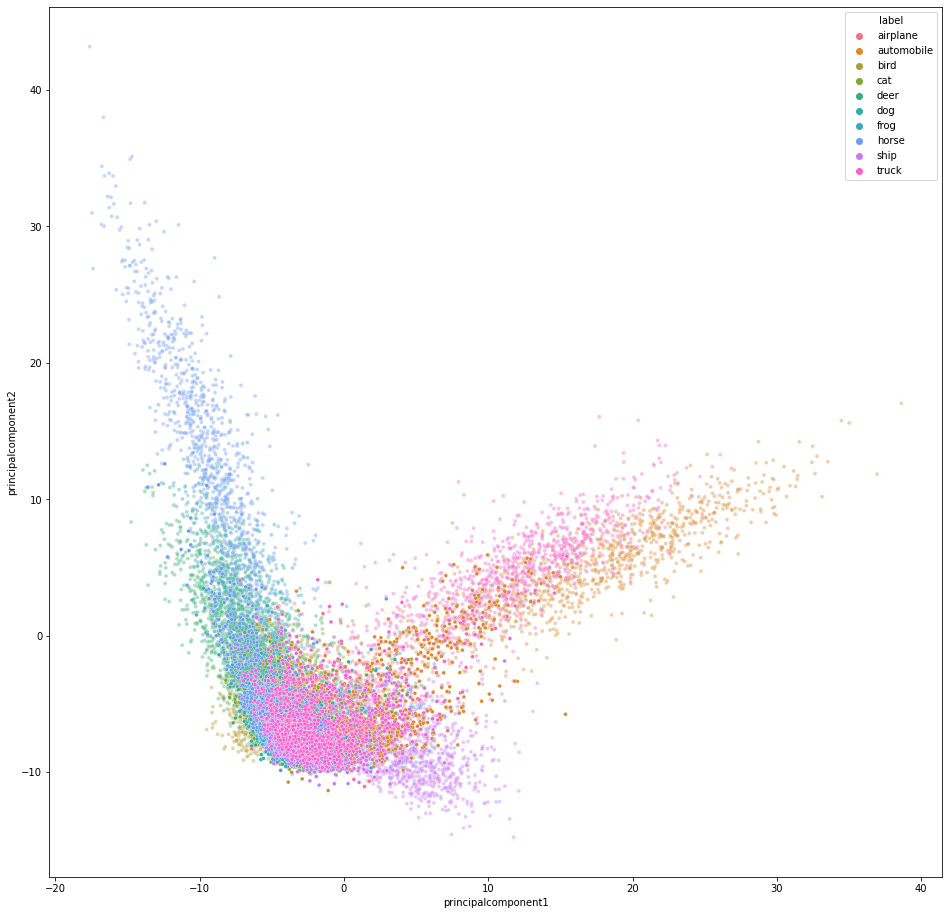

<Figure size 2160x2160 with 0 Axes>

In [24]:
principalDf = pd.concat([df2,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]

fig = plt.gcf()
fig.set_size_inches(16,16)

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9226], s = 15, alpha = .4,
           hue='label', legend=True)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9226:], s = 15, alpha = 1,
           hue='label', legend=False)



plt.figure(figsize=(30,30))

<Figure size 2160x2160 with 0 Axes>

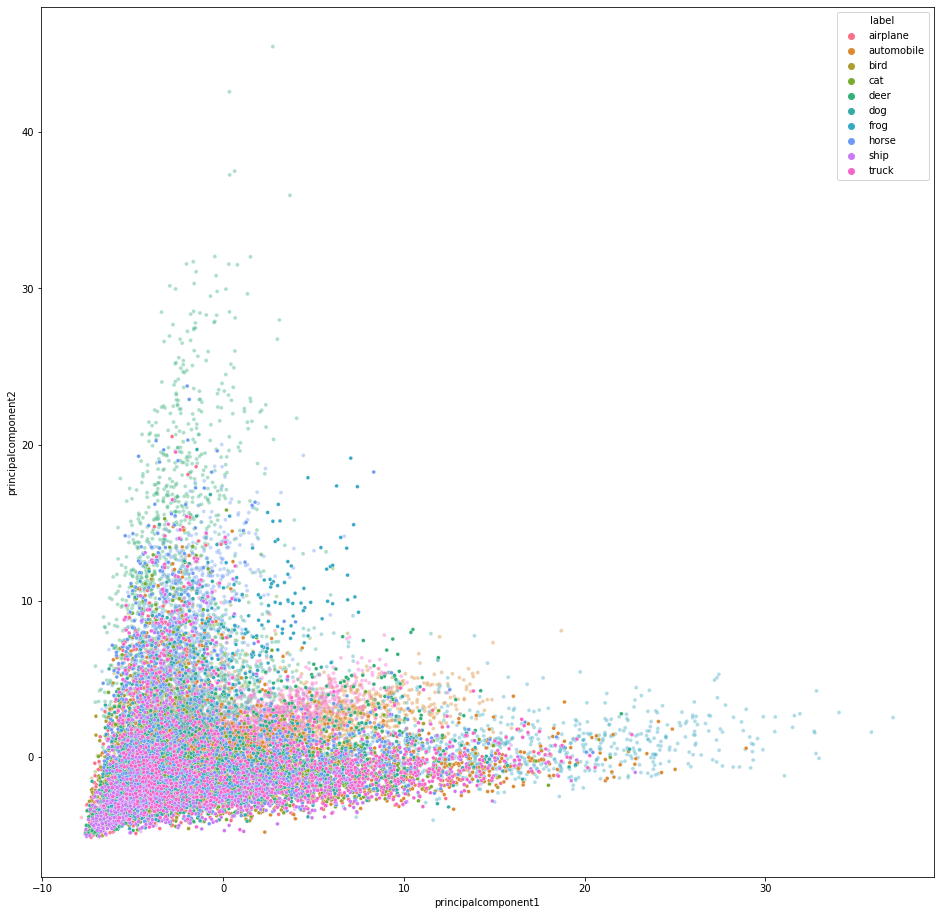

<Figure size 2160x2160 with 0 Axes>

In [28]:
principalDf = pd.concat([df3,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]

fig = plt.gcf()
fig.set_size_inches(16,16)

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:9226], s = 15, alpha = .4,
           hue='label', legend=True)

sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[9226:], s = 15, alpha = 1,
           hue='label', legend=False)



plt.figure(figsize=(30,30))